# CIFAR10 Classifier

In [138]:
import torch
import torchvision
import torchvision.transforms as transforms

## Prepare Data

In [165]:
valid_ratio = 0.3
batch_size = 128
transform = transforms.Compose([transforms.ToTensor()])

cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

num_train = int((1.0 - valid_ratio) * len(cifar_train))
num_valid = int(valid_ratio * len(cifar_train))

train_set, valid_set = torch.utils.data.dataset.random_split(cifar_train, [num_train, num_valid])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Boat', 'Truck')



Files already downloaded and verified


# Visualize Dataset


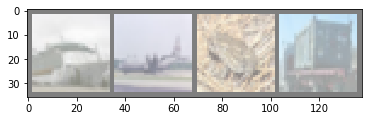

Boat Airplane  Frog Truck


In [166]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get iterater for loaded training images
dataiter = iter(train_loader)

# get the next batch of images and labels
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4,]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define CNN

In [167]:
import torch.nn as nn 
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=0)

        self.fc1 = nn.Linear(16 * 6 * 6, 512) # Flatten output of previous layer
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        #input layer
        x = x
        
        # layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        # layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        # layer 3
        x = self.conv3(x)
        x = F.relu(x)
  
        # layer 4
        # reshape by multiplying dimensions of x after previous layer
        x = x.view(-1, 16 * 6 * 6) 
        x = self.fc1(x)
        x = F.relu(x)

        # layer 5
        x = self.fc2(x)
        x = F.relu(x)
        
        # Output layer
        x = self.fc3(x)

        return x


## Training Loop

In [168]:
def get_num_correct(predictions, labels):
  return predictions.argmax(dim=1).eq(labels).sum().item()

In [177]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

for lr in [0.0005, 0.00075, 0.001, 0.0025, 0.005]:
    network = Network()
    optimizer = optim.Adam(network.parameters(), lr=lr) # parameters are weights and baises

    train_loss = []
    valid_loss = []
    for epoch in range(10):
        train_correct = 0
        batch_loss = []
        for batch in train_loader:
            images, labels = batch

            predictions = network(images)
            loss = F.cross_entropy(predictions, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
            train_correct += get_num_correct(predictions, labels)
        
        train_loss.append(sum(batch_loss)/len(batch_loss))
        with torch.no_grad():
            batch_loss = []
            valid_correct = 0
            for batch in valid_loader:
                images, labels = batch

                predictions = network(images)
                loss = F.cross_entropy(predictions, labels)
                batch_loss.append(loss.item())
                valid_correct += get_num_correct(predictions, labels)
            
            valid_loss.append(sum(batch_loss)/len(batch_loss))
        
        print(f"epoch: {epoch} \t train loss: {train_loss[-1]: .3f} \t train accuracy: {train_correct/len(train_set): .3f} \t valid loss: {valid_loss[-1]: .3f} \t valid accuracy: {valid_correct/len(valid_set):.3f}")

        plt.figure()
        plt.plot(train_loss, label="Train Loss")
        plt.plot(valid_loss, label="Valid Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"Optimizer: Adam, Learning Rate: {lr}")
        plt.legend()





## Training Visualization

In [0]:
plt.plot(train_loss, label="Train Loss")
plt.plot(valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Prepare Testing Data















In [0]:
# transform = transforms.Compose([transforms.ToTensor()])

cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=True)

## Calculate Testing Accuracy

In [0]:
total_correct = 0
for batch in test_loader:
    images, labels = batch
    predictions = network(images)
    total_correct += predictions.argmax(dim=1).eq(labels).sum().item()

print(f"Test accuracy: {total_correct/len(cifar_test)}")